# Створення базових моделей

**Частина 1**

Необхідно визначити в коді натупне:

1. Базову модель для навчання (виберіть який тип моделі хочете натренувати CNN, MLP тощо).
2. Початкову кількість шарів та їх параметри.
3. Функції для тренування та валідації, візуалізації результатів, фінкцію втрат та метрику перевірки результатів.
4. Натренуйте модель і перевірте результат. Яке значення функції втрат, яка метрика вашої моделі після навчання? Візуалізуйте графіки навчання. Скільки часу потрібно було на тренування?

**Частина 2**

1. Опишіть гіперпараметри моделі: кількість шарів/кількість нейронів в шарах, різні їх комбінації.
2. Підберіть та перевірте найкращі гіперпараметри вашої моделі за яких метрика під час валідації буде найвищою. Скільки часу потрібно було на підбір гіперпараметрів моделі?
3. Продемонструйте на яких класах та зображеннях найчастіше помиляється найкраща модель.
4. Візуалізувати графіки залежностей між гіперпараметрами найкращої моделі і змінами значень її метрики.

## Resources and references
- [Experiment Tracking and Hyperparameter Tuning with TensorBoard in PyTorch](https://www.akshaymakes.com/blogs/experiment-tracking)
- [Fashion MNIST with Pytorch (93% Accuracy)](https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy|)
- [PyTorch Documentation](https://pytorch.org/docs/stable/optim.html)

## Imports and setup

In [1]:
%pip install -q torchinfo torchmetrics tensorboard

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
from datetime import datetime
import time

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader

from torchvision.datasets import FashionMNIST
import torchmetrics
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

## Device configuration

In [3]:
def get_device():
    if torch.backends.mps.is_available():
        print("Running on the MPS")
        return torch.device("mps")
    if torch.cuda.is_available():
        print("Running on the GPU")
        return torch.device("cuda")
    print("Running on the CPU")
    return torch.device("cpu")

In [4]:
device = get_device()

Running on the MPS


## Dataset

### Download train and test dataset using torchvision

In [5]:
training_dataset = FashionMNIST("./data", download=True, train=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_dataset = FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

print(f"Number of Images in test dataset is {len(test_dataset)}")
print(f"Number of Images in training dataset is {len(training_dataset)}")

Number of Images in test dataset is 10000
Number of Images in training dataset is 60000


In [6]:
BATCH_SIZE = 100

train_loader = torch.utils.data.DataLoader(training_dataset,
                                           batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE)

### Visualize some images

In [7]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
demo_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch

labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

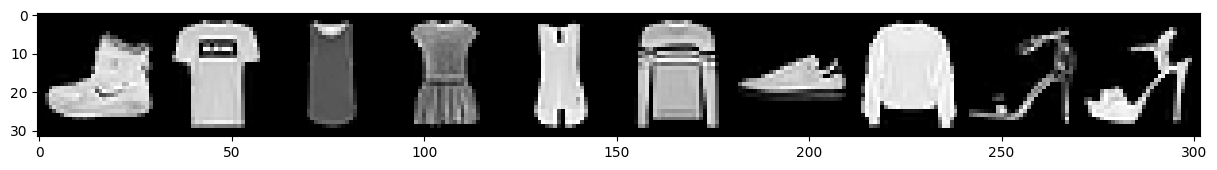

In [10]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

## Model

In [11]:
class TinyVGG(nn.Module):
    """
    A small VGG-like network for image classification.

    Args:
        in_channels (int): The number of input channels.
        n_classes (int): The number of output classes.
        hidden_units (int): The number of hidden units in each convolutional block.
        n_conv_blocks (int): The number of convolutional blocks.
        dropout (float): The dropout rate.
    """

    def __init__(self, in_channels, n_classes, hidden_units, n_conv_blocks, dropout):
        super().__init__()
        self.in_channels = in_channels
        self.out_features = n_classes
        self.dropout = dropout
        self.hidden_units = hidden_units

        # Input block
        self.input_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, padding=0, stride=1),
            nn.Dropout(dropout),
            nn.ReLU(),
        )

        # Convolutional blocks
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0, stride=1),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ) for _ in range(n_conv_blocks)
        ])

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=256),
            nn.Dropout(dropout),
            nn.Linear(in_features=256, out_features=64),
            nn.Linear(in_features=64, out_features=n_classes),
        )

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """

        x = self.input_block(x)
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = self.classifier(x)
        return x

## Training and test step functions

In [12]:
def train_step(dataloader, model, optimizer, criterion, device, train_acc_metric):
    """
    Perform a single training step.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader for the training data.
        model (torch.nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer for the model.
        criterion (torch.nn.Module): The loss function for the model.
        device (torch.device): The device to train the model on.
        train_acc_metric (torchmetrics.Accuracy): The accuracy metric for the model.

    Returns:
        The accuracy of the model on the training data.
    """

    for (X, y) in tqdm(dataloader):
        # Move the data to the device.
        X = X.to(device)
        y = y.to(device)

        # Forward pass.
        y_preds = model(X)

        # Calculate the loss.
        loss = criterion(y_preds, y)

        # Calculate the accuracy.
        train_acc_metric.update(y_preds, y)

        # Backpropagate the loss.
        loss.backward()

        # Update the parameters.
        optimizer.step()

        # Zero the gradients.
        optimizer.zero_grad()

    return train_acc_metric.compute()

In [13]:
def test_step(dataloader, model, device, test_acc_metric):
    """
    Perform a single test step.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader for the test data.
        model (torch.nn.Module): The model to test.
        device (torch.device): The device to test the model on.
        test_acc_metric (torchmetrics.Accuracy): The accuracy metric for the model.

    Returns:
        The accuracy of the model on the test data.
    """

    for (X, y) in tqdm(dataloader):
        # Move the data to the device.
        X = X.to(device)
        y = y.to(device)

        # Forward pass.
        y_preds = model(X)

        # Calculate the accuracy.
        test_acc_metric.update(y_preds, y)

    return test_acc_metric.compute()

## TensorBoard Summary Writer

In [14]:
def create_writer(
    experiment_name: str, model_name: str, conv_layers, dropout, hidden_units, learning_rate, optimizer_name
) -> SummaryWriter:
    """
    Create a SummaryWriter object for logging the training and test results.

    Args:
        experiment_name (str): The name of the experiment.
        model_name (str): The name of the model.
        conv_layers (int): The number of convolutional layers in the model.
        dropout (float): The dropout rate used in the model.
        hidden_units (int): The number of hidden units in the model.

    Returns:
        SummaryWriter: The SummaryWriter object.
    """

    timestamp = str(datetime.now().strftime("%d-%m-%Y_%H-%M-%S"))
    log_dir = os.path.join(
        "runs",
        timestamp,
        experiment_name,
        model_name,
        f"convlayers_{conv_layers}",
        f"dropout_{dropout}",
        f"hid_unit{hidden_units}",
        f"lr_{learning_rate}",
        f"optimizer_{optimizer_name}",
    ).replace("\\", "/")
    return SummaryWriter(log_dir=log_dir)

## Hyperparameters automatic search

In [15]:
EPOCHS = 5

In [16]:
"""
The hyperparameters that are tuned are the number of convolutional layers, the dropout rate, the number of hidden units, learning rate, and the optimizer.
"""

# Hyperparameters to try out
hparams_config = {
    "n_conv_layers": [1, 2, 3],
    "dropout": [0.0, 0.25, 0.5],
    "hidden_units": [128, 256, 512],
    "learning_rate": [ 0.0007, 0.001, 0.0015],
    "optimizers": ['Adam', 'SGD']
}

# Hyperparameters to try out
hparams_config = {
    "n_conv_layers": [1, 2],
    "dropout": [0, 0.25],
    "hidden_units": [128, 256],
    "learning_rate": [ 0.0007, 0.001],
    "optimizers": ['Adam']
}

# Calculate the total number of combinations
total_combinations = 1
for key, values in hparams_config.items():
    total_combinations *= len(values)

print("Total number of combinations:", total_combinations)

Total number of combinations: 16


In [17]:
"""
This code performs hyperparameter tuning for a TinyVGG model.

The hyperparameters that are tuned are the number of convolutional layers, the dropout rate, and the number of hidden units.

The results of the hyperparameter tuning are logged to a TensorBoard file.
"""

os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
experiment_number = 0

for n_conv_layers in hparams_config["n_conv_layers"]:
    for dropout in hparams_config["dropout"]:
        for hidden_units in hparams_config["hidden_units"]:
            for learning_rate in hparams_config["learning_rate"]:
                for optimizer_name in hparams_config["optimizers"]:
                    experiment_number += 1
                    print(
                        f"\nTuning Hyper Parameters || Conv Layers: {n_conv_layers} || Dropout: {dropout} || Hidden Units: {hidden_units} || Learnin rate: {learning_rate} || Optimizer: {optimizer_name}\n"
                    )

                    # Create the model and move it to the device
                    model = TinyVGG(
                        in_channels=1,
                        n_classes=len(training_dataset.classes),
                        hidden_units=hidden_units,
                        n_conv_blocks=n_conv_layers,
                        dropout=dropout,
                    ).to(device)

                    # Create the optimizer and loss function
                    if optimizer_name == 'Adam':
                        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
                    elif optimizer_name == 'SGD':
                        optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
                    else:
                        optimizer = None
                    criterion = torch.nn.CrossEntropyLoss()

                    # Create the accuracy metrics
                    train_acc_metric = torchmetrics.Accuracy(
                        task="multiclass", num_classes=len(training_dataset.classes)
                    ).to(device)
                    test_acc_metric = torchmetrics.Accuracy(
                        task="multiclass", num_classes=len(training_dataset.classes)
                    ).to(device)

                    # Create the TensorBoard writer
                    writer = create_writer(
                        experiment_name=f"{experiment_number}",
                        model_name="tiny_vgg",
                        conv_layers=n_conv_layers,
                        dropout=dropout,
                        hidden_units=hidden_units,
                        learning_rate=learning_rate,
                        optimizer_name=optimizer_name,
                    )

                    # Start measuring the training time
                    start_time = time.time()

                    # Train the model
                    for epoch in range(EPOCHS):
                        train_step(
                            train_loader,
                            model,
                            optimizer,
                            criterion,
                            device,
                            train_acc_metric,
                        )
                        test_step(test_loader, model, device, test_acc_metric)
                        writer.add_scalar(
                            tag="Training Accuracy",
                            scalar_value=train_acc_metric.compute(),
                            global_step=epoch,
                        )
                        writer.add_scalar(
                            tag="Test Accuracy",
                            scalar_value=test_acc_metric.compute(),
                            global_step=epoch,
                        )

                    # Calculate and log the total training time
                    total_training_time = time.time() - start_time
                    writer.add_scalar('Training/TotalTrainingTime', total_training_time)

                     # Save the model state dictionary to a file
                    model_file_path = f"model_nconv{n_conv_layers}_dropout{dropout}_hidden{hidden_units}_lr{learning_rate}_{optimizer_name}_{experiment_number}.pt"
                    torch.save(model.state_dict(), model_file_path)

                    # Add the hyperparameters and metrics to TensorBoard
                    writer.add_hparams(
                        {
                            "conv_layers": n_conv_layers,
                            "dropout": dropout,
                            "hidden_units": hidden_units,
                            "learning_rate": learning_rate,
                            "optimizer": optimizer_name,
                        },
                        {
                            "train_acc": train_acc_metric.compute(),
                            "test_acc": test_acc_metric.compute(),
                            "total_training_time": total_training_time,
                        },
                    )


Tuning Hyper Parameters || Conv Layers: 1 || Dropout: 0 || Hidden Units: 128 || Learnin rate: 0.0007 || Optimizer: Adam



/Library/Python/3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 100/100 [00:01<00:00, 59.39it/s]



Tuning Hyper Parameters || Conv Layers: 1 || Dropout: 0 || Hidden Units: 128 || Learnin rate: 0.001 || Optimizer: Adam



100%|██████████| 100/100 [00:01<00:00, 58.64it/s]



Tuning Hyper Parameters || Conv Layers: 1 || Dropout: 0 || Hidden Units: 256 || Learnin rate: 0.0007 || Optimizer: Adam



100%|██████████| 100/100 [00:03<00:00, 29.83it/s]



Tuning Hyper Parameters || Conv Layers: 1 || Dropout: 0 || Hidden Units: 256 || Learnin rate: 0.001 || Optimizer: Adam



100%|██████████| 100/100 [00:02<00:00, 36.77it/s]



Tuning Hyper Parameters || Conv Layers: 1 || Dropout: 0.25 || Hidden Units: 128 || Learnin rate: 0.0007 || Optimizer: Adam



100%|██████████| 100/100 [00:02<00:00, 44.59it/s]



Tuning Hyper Parameters || Conv Layers: 1 || Dropout: 0.25 || Hidden Units: 128 || Learnin rate: 0.001 || Optimizer: Adam



100%|██████████| 100/100 [00:02<00:00, 45.92it/s]



Tuning Hyper Parameters || Conv Layers: 1 || Dropout: 0.25 || Hidden Units: 256 || Learnin rate: 0.0007 || Optimizer: Adam



100%|██████████| 100/100 [00:03<00:00, 28.89it/s]



Tuning Hyper Parameters || Conv Layers: 1 || Dropout: 0.25 || Hidden Units: 256 || Learnin rate: 0.001 || Optimizer: Adam



100%|██████████| 100/100 [00:03<00:00, 28.71it/s]



Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0 || Hidden Units: 128 || Learnin rate: 0.0007 || Optimizer: Adam



100%|██████████| 100/100 [00:01<00:00, 79.66it/s]



Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0 || Hidden Units: 128 || Learnin rate: 0.001 || Optimizer: Adam



100%|██████████| 100/100 [00:01<00:00, 80.35it/s]



Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0 || Hidden Units: 256 || Learnin rate: 0.0007 || Optimizer: Adam



100%|██████████| 100/100 [00:02<00:00, 40.03it/s]



Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0 || Hidden Units: 256 || Learnin rate: 0.001 || Optimizer: Adam



100%|██████████| 100/100 [00:02<00:00, 37.08it/s]



Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0.25 || Hidden Units: 128 || Learnin rate: 0.0007 || Optimizer: Adam



100%|██████████| 100/100 [00:02<00:00, 38.41it/s]



Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0.25 || Hidden Units: 128 || Learnin rate: 0.001 || Optimizer: Adam



100%|██████████| 100/100 [00:02<00:00, 37.55it/s]



Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0.25 || Hidden Units: 256 || Learnin rate: 0.0007 || Optimizer: Adam



100%|██████████| 100/100 [00:03<00:00, 30.69it/s]



Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0.25 || Hidden Units: 256 || Learnin rate: 0.001 || Optimizer: Adam



100%|██████████| 100/100 [00:03<00:00, 29.23it/s]


## Results analysis

Code below allows to compare the performance of different models using TensorBoard. During model training the results are logged to a TensorBoard files in `runs` folder. The code below loads the TensorBoard files in the folder and displays the results.

It also contains graphs that visualizer how accuracy grows accross epochs for each model. The training time for each model is also added in information.

By default, TensorBoard is available at http://localhost:6006/.

In [20]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

## Answers to Part II questions

Model used is a based on TinyVGG model. Sample code that was used to create the model is available in `resources` cell of the Notebook.

The model actively uses convolution layers. Number of convolutional layers is one of the hyperparameters available to test and change, as well as number of hidden units and dropout rate.

Whole model configuration can be seen in respective code block.

The model was trained for 5 epochs. The training time for each model is available in TensorBoard.

Best hyperparameters turned out to be the following:
- Number of convolutional layers: 1
- Dropout rate: 0.0
- Number of hidden units: 256
- Learning rate: 0.0007
- Optimizer: Adam

It achieved test accuracy of 0.89624.
However, accuracy does not differ greatly across most model hyperparameter configuration, as can be seen in TensorBoard. Probably, in case of restarting the training process, the results would be different and some other of the top models can achieve a little bit better accuracy (due to randomness of weight initialization).

At the last run, second-best model achieved test accuracy of 0.89586. It had the following hyperparameters:
- Number of convolutional layers: 2
- Dropout rate: 0.0
- Number of hidden units: 256
- Learning rate: 0.001
- Optimizer: Adam

Training time is between 1.5 minutes and 5 minutes, depending on the model. However, those times are accurate for `mps` device and may be significantly longer in case of `cpu` device.


## Accuracy in each class of FashionMNIST dataset

Results here are displayed for the best model of the last run.

/Library/Python/3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 100/100 [00:01<00:00, 85.49it/s]


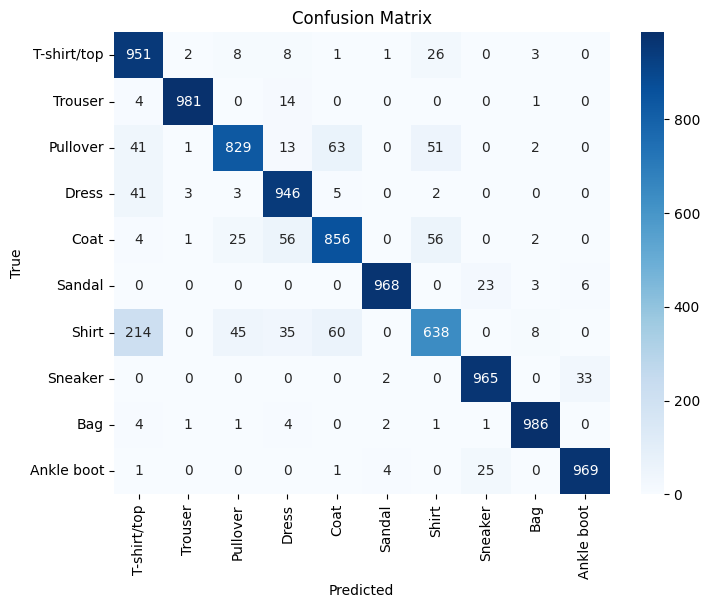

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = TinyVGG(in_channels=1,
                n_classes=len(training_dataset.classes),
                hidden_units=128,
                n_conv_blocks=1,
                dropout=0.0,
                ).to(device)

# Create the optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0007)
criterion = torch.nn.CrossEntropyLoss()


# Create the accuracy metrics
train_acc_metric = torchmetrics.Accuracy(
                        task="multiclass", num_classes=len(training_dataset.classes)
                    ).to(device)
test_acc_metric = torchmetrics.Accuracy(
                        task="multiclass", num_classes=len(training_dataset.classes)
                    ).to(device)

# Train the model
for epoch in range(EPOCHS):
    train_step(
        train_loader,
        model,
        optimizer,
        criterion,
        device,
        train_acc_metric,
    )
    test_step(test_loader, model, device, test_acc_metric)

# Calculate confusion matrix after training
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

# Display confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
class_names = [str(i) for i in training_dataset.classes]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
